# Script: CoxNet selected model - Survival analyses
## Author: Lennart Hohmann

In [106]:
################################################################################
# SET UP
################################################################################

import os
import sys
import time
import numpy as np
import pandas as pd
import joblib
#from sksurv.util import Surv
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
from sklearn.preprocessing import OneHotEncoder

# Set working directory
os.chdir(os.path.expanduser("~/PhD_Workspace/PredictRecurrence/"))

# Import custom CoxNet functions
sys.path.append("/Users/le7524ho/PhD_Workspace/PredictRecurrence/src/")
from src.utils import (
    log,
    load_training_data,
    beta2m,
    subset_methylation)
from src.annotation_functions import (
    run_univariate_cox_for_cpgs
)

In [107]:
################################################################################
# INPUT FILES
################################################################################

# Input files
infile_betavalues = "./data/train/train_methylation_unadjusted.csv" # ⚠️ ADAPT
infile_clinical = "./data/train/train_clinical.csv"
infile_outerfold = "./output/CoxNet/ERpHER2n/Combined/Unadjusted/best_outer_fold.pkl" # ⚠️ ADAPT
infile_train_ids = "./data/train/train_subcohorts/ERpHER2n_train_ids.csv" # sample ids of training cohort


In [108]:

################################################################################
# PARAMS
################################################################################

# Output directory and files
output_dir = "output/CoxNet/Selected_model/" # ⚠️ ADAPT
os.makedirs(output_dir, exist_ok=True)
outfile_univariate_cox = os.path.join(output_dir, "testset_univariate_cox.csv")


In [ ]:

# MAIN CODE

# Load and prepare data
train_ids = pd.read_csv(infile_train_ids, header=None).iloc[:, 0].tolist()
beta_matrix, clinical_data = load_training_data(train_ids, infile_betavalues, infile_clinical)

# convert to M-values
mvals = beta2m(beta_matrix, beta_threshold=0.001)
infile_cpg_ids = "./data/set_definitions/CpG_prefiltered_sets/cpg_ids_atac_overlap.txt"

# admin censoring for tnbc
# subset methylation atac overlap (needed to match ids)
mvals = subset_methylation(mvals,infile_cpg_ids)
X = mvals.copy()


Loaded training data.
Successfully loaded 205799 CpG IDs for pre-filtering.
Successfully subsetted methylation data to 193246 pre-filtered CpGs.


In [110]:
# Columns to compute variance on = all except keep_vars
pool_cols = X.columns

# Compute variance
variances = X[pool_cols].var(axis=0)

In [111]:
import matplotlib.pyplot as plt


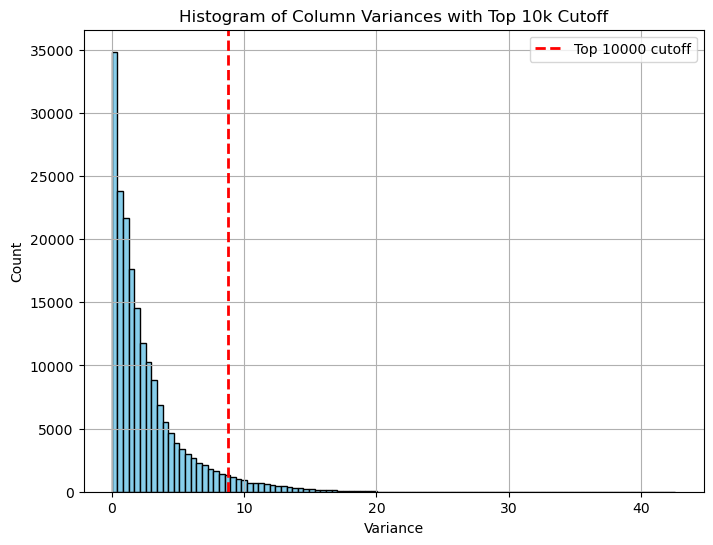

In [137]:
# Determine the cutoff for the top 10k most varying columns
top_k = 10000
cutoff_value = np.sort(variances)[-top_k]  # top_k largest values

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(variances, bins=100, color='skyblue', edgecolor='black')

# Draw vertical line at the cutoff
plt.axvline(cutoff_value, color='red', linestyle='dashed', linewidth=2,
            label=f'Top {top_k} cutoff')

plt.legend()
plt.grid(True)
plt.xlabel('Variance')
plt.ylabel('Count')
plt.title('Histogram of Column Variances with Top 10k Cutoff')
plt.show()

In [125]:
int(len(variances)*0.01)

1932

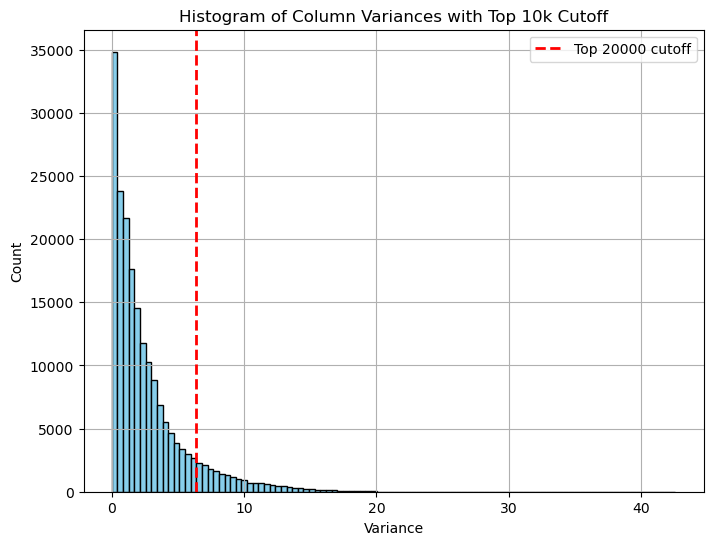

In [134]:
# Determine the cutoff for the top 10k most varying columns
top_k = 20000#int(len(variances)*0.005)
cutoff_value = np.sort(variances)[-top_k]  # top_k largest values

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(variances, bins=100, color='skyblue', edgecolor='black')

# Draw vertical line at the cutoff
plt.axvline(cutoff_value, color='red', linestyle='dashed', linewidth=2,
            label=f'Top {top_k} cutoff')

plt.legend()
plt.grid(True)
plt.xlabel('Variance')
plt.ylabel('Count')
plt.title('Histogram of Column Variances with Top 10k Cutoff')
plt.show()

In [58]:
len(X.index.tolist())

1008

In [59]:
# onehot encode cat clinvars
# subset clinical data aligned to X
clin = clinical_data[["Age", "Size.mm", "NHG", "LN"]].loc[X.index]
# one-hot encode the categorical clinical variables
encoder = OneHotEncoder(drop=None, dtype=float, sparse_output=False)
encoded = encoder.fit_transform(clin[["NHG", "LN"]])

encoded_cols = encoder.get_feature_names_out(["NHG", "LN"]).tolist()

# make a DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=X.index)
# build the encoded clinical DataFrame (drop original categorical cols)
clin_encoded = pd.concat([clin.drop(columns=["NHG", "LN"]), encoded_df], axis=1)
# concatenate encoded clinical back into X
X = pd.concat([X, clin_encoded], axis=1).copy()

# build clinvars_included_encoded: replace original categorical names with encoded column names
clinvars_included_encoded = [c for c in ["Age", "Size.mm", "NHG", "LN"] if c not in ["NHG", "LN"]] + encoded_cols
log(f"Added {clinvars_included_encoded} clinical variables. New X shape: {X.shape}")


=== Added ['Age', 'Size.mm', 'NHG_1', 'NHG_2', 'NHG_3', 'LN_N+', 'LN_N0'] clinical variables. New X shape: (1008, 193253) ===



In [60]:
# best outer fold
selected_fold = joblib.load(infile_outerfold)
print(selected_fold.keys())


dict_keys(['fold', 'model', 'train_idx', 'test_idx', 'train_ids', 'test_ids', 'cv_results', 'features_after_filter1', 'features_after_filter2', 'input_training_features', 'error'])


In [82]:
print(f"Best cv fold: {selected_fold['fold']}")
selected_model = selected_fold['model']
bm_testidx = selected_fold["test_idx"].tolist() 
bm_trainidx = selected_fold["train_idx"].tolist()
bm_testids = selected_fold["test_ids"].tolist() 
bm_trainids = selected_fold["train_ids"].tolist()
input_training_features = selected_fold["input_training_features"].tolist()

selected_fold["model"]


Best cv fold: 3


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['Age', 'Size.mm',
                                                   'cg27626141', 'cg07808087',
                                                   'cg22162544', 'cg21004358',
                                                   'cg23879118', 'cg23714330',
                                                   'cg04894169', 'cg24504954',
                                                   'cg00106685', 'cg08604594',
                                                   'cg14083800', 'cg10817615',
                                                   'cg01053463', 'cg17882374',
                                                   'cg17373656', 'cg02144266',
                                                   'cg10861005', 'cg26624794',
                                                   'cg0...
                                                   'cg24876960', 'cg00481499',
                                                   'cg03885684', 'cg08825929',
                                                   'cg11173636', 'cg02159896', ...]),
                                                 ('passthrough_encoded',
                                                  'passthrough',
                                                  ['NHG_1', 'NHG_2', 'NHG_3',
                                                   'LN_N+', 'LN_N0'])],
                                   verbose_feature_names_out=False)),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.022666748333071255],
                                        fit_baseline_model=True, l1_ratio=0.7,
                                        penalty_factor=array([0., 0., 1., ..., 0., 0., 0.])))])

In [62]:
from sksurv.util import Surv

y = Surv.from_dataframe("RFi_event", "RFi_years", clinical_data)

In [63]:
y[1:5]

array([(False, 10.66575342), (False, 10.71506849), (False, 10.69589041),
       ( True,  5.25479452)],
      dtype=[('RFi_event', '?'), ('RFi_years', '<f8')])

In [64]:
# calc median follow up time
clin_mf = clinical_data.copy()
#clinical_data['RFi_years'].median()
clin_mf['reverse_event'] = 1 - clin_mf['RFi_event']
kmf = KaplanMeierFitter()
kmf.fit(durations=clin_mf['RFi_years'], event_observed=clin_mf['reverse_event'])
median_followup = kmf.median_survival_time_
print(f"Median follow-up time (Reverse KM): {median_followup:.2f} years")

# survival analyses
#y = Surv.from_dataframe("RFi_event", "RFi_years", clinical_data)


Median follow-up time (Reverse KM): 5.45 years


In [84]:
################################################################################
# define clin test and train data of that outer fold
################################################################################
log("Defining clinical test and train data of selected outer fold!")

X_test = X.loc[bm_testids,input_training_features].copy()
clin_test = clinical_data.loc[bm_testids,:].copy()

X_train = X.loc[bm_trainids,input_training_features].copy()
clin_train = clinical_data.loc[bm_trainids,:].copy()



=== Defining clinical test and train data of selected outer fold! ===



In [85]:
X_test.head()
clin_test.head()

,ER,PR,HER2,LN,NHG,Size.mm,TreatGroup,InvCa.type,Age,NCN.PAM50,OS_event,RFi_event,OS_years,RFi_years,Group,NHG_missing
Sample,,,,,,,,,,,,,,,,
S000226,Positive,Positive,Negative,N+,1,15,ChemoEndo,Ductal,40,LumA,0,0,10.909589,10.613699,ER+HER2-,0
S000393,Positive,Positive,Negative,N+,2,11,ChemoEndo,Ductal,50,LumA,1,1,7.986301,7.871233,ER+HER2-,0
S000601,Positive,Positive,Negative,N0,3,16,ChemoEndo,Ductal,45,LumB,0,0,10.600000,10.306849,ER+HER2-,0
S000602,Positive,Positive,Negative,N+,2,32,ChemoEndo,Ductal,65,LumB,0,0,10.608219,10.315068,ER+HER2-,0
S000763,Positive,Positive,Negative,N+,2,23,ChemoEndo,Ductal,50,Her2,0,0,10.504110,10.210959,ER+HER2-,0


In [86]:
selected_model.named_steps

{'columntransformer': ColumnTransformer(transformers=[('scale', StandardScaler(),
                                  ['Age', 'Size.mm', 'cg27626141', 'cg07808087',
                                   'cg22162544', 'cg21004358', 'cg23879118',
                                   'cg23714330', 'cg04894169', 'cg24504954',
                                   'cg00106685', 'cg08604594', 'cg14083800',
                                   'cg10817615', 'cg01053463', 'cg17882374',
                                   'cg17373656', 'cg02144266', 'cg10861005',
                                   'cg26624794', 'cg01957330', 'cg11102724',
                                   'cg06511389', 'cg16970232', 'cg24876960',
                                   'cg00481499', 'cg03885684', 'cg08825929',
                                   'cg11173636', 'cg02159896', ...]),
                                 ('passthrough_encoded', 'passthrough',
                                  ['NHG_1', 'NHG_2', 'NHG_3', 'LN_N+',
        

In [89]:
# inspect model hyperparameters and coefficients

# Unpack estimator from pipeline
coxnet = selected_model.named_steps["coxnetsurvivalanalysis"]

# Now access alpha and coefficients
alpha_used = coxnet.alphas_[0]  # or simply: coxnet.alphas_[0]
print("alpha =", alpha_used)
print("L1 ratio:", coxnet.l1_ratio)

# Get non-zero coefficients
coefs = coxnet.coef_.flatten()
nonzero_mask = coefs != 0

nonzero_features = X_train.columns[nonzero_mask]

nonzero_features.shape
print(f"Number of non-zero coefficients: {np.sum(nonzero_mask)}")


alpha = 0.022666748333071255
L1 ratio: 0.7
Number of non-zero coefficients: 145


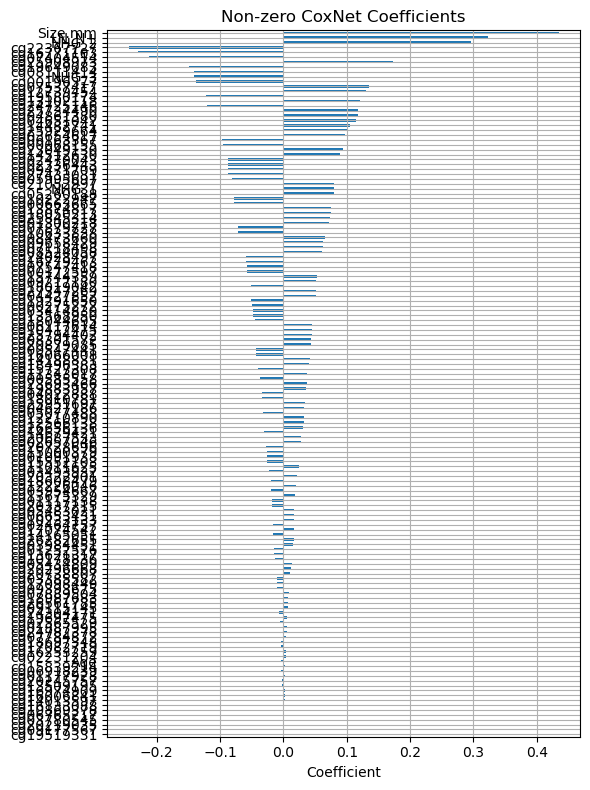

In [91]:
# plot
coefs_df = pd.DataFrame(coefs, index=X_train.columns, columns=["coefficient"])
non_zero_coefs = coefs_df[coefs_df["coefficient"] != 0]
# Sort by absolute coefficient size for plotting
coef_order = non_zero_coefs["coefficient"].abs().sort_values().index
non_zero_coefs = non_zero_coefs.loc[coef_order]

fig, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.plot.barh(ax=ax, legend=False)
ax.set_xlabel("Coefficient")
ax.set_title("Non-zero CoxNet Coefficients")
ax.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig(os.path.join(output_dir, "coxnet_nonzero_coefficients.png"), dpi=300, bbox_inches="tight")
#plt.close()
#print(f"Saved coefficient plot with {len(non_zero_coefs)} non-zero features.")


In [92]:
################################################################################
# Compute univar cox on test set for included cpgs
################################################################################
log("Computing univar cox on test set per cpg!")

uv_res = run_univariate_cox_for_cpgs(mval_matrix=X_test[nonzero_features],
                                 clin_data=clin_test,
                                 time_col="RFi_years",
                                 event_col="RFi_event")
# Format for nice logging
uv_res["HR"] = uv_res["HR"].astype(float).map(lambda x: f"{x:.2f}")
uv_res["CI_lower"] = uv_res["CI_lower"].astype(float).map(lambda x: f"{x:.2f}")
uv_res["CI_upper"] = uv_res["CI_upper"].astype(float).map(lambda x: f"{x:.2f}")
uv_res["pval"] = uv_res["pval"].astype(float).map(lambda x: f"{x:.3g}")
uv_res["padj"] = uv_res["padj"].astype(float).map(lambda x: f"{x:.3g}")

# Print only selected columns
uv_res = uv_res.sort_values(by="CpG_ID")
print(uv_res[["CpG_ID", "HR", "CI_lower","CI_upper","pval", "padj"]].to_string(index=False))
#uv_res.to_csv(outfile_univariate_cox, index=False)



=== Computing univar cox on test set per cpg! ===


=== Starting univariate Cox regression for 145 CpGs... ===


===   Processing CpG 145/145... ===


=== Univariate Cox regression filtering complete. ===

    CpG_ID   HR CI_lower CI_upper     pval   padj
       Age 0.99     0.96     1.03    0.652  0.865
     LN_N+ 4.83     1.65    14.13  0.00402  0.146
     NHG_1 0.42     0.09     2.09     0.29  0.683
     NHG_2 0.80     0.32     2.02    0.637  0.865
     NHG_3 1.99     0.77     5.13    0.154  0.575
   Size.mm 1.06     1.03     1.09 0.000153 0.0222
cg00068155 0.92     0.77     1.11    0.396  0.726
cg00172597 1.05     0.87     1.26    0.622  0.865
cg00196377 1.03     0.87     1.22    0.695  0.891
cg00275272 1.02     0.87     1.20    0.787  0.943
cg00547441 0.87     0.75     1.01   0.0684   0.45
cg00585558 0.92     0.81     1.05    0.229  0.639
cg00663665 0.91     0.80     1.03    0.118  0.518
cg01091938 1.07     0.89     1.27    0.488   0.76
cg01117138 1.17     1.01     1.35   0.0316 

In [93]:

################################################################################
# Compute risk scores on training set to get cutoffs
################################################################################
log("Computing risk scores on training set to get cutoffs!")

risk_scores_train = selected_model.predict(X_train)
risk_scores_train = pd.Series(risk_scores_train, index=X_train.index)
median_cutoff = risk_scores_train.median()  # define median cutoff from training risk scores
print(f"Median-based cutoff: {median_cutoff:.4f}")



=== Computing risk scores on training set to get cutoffs! ===

Median-based cutoff: -0.1941


In [94]:

################################################################################
# Compute predictiveness-based cutoff
################################################################################

sorted_scores = np.sort(risk_scores_train.values)
event_rate = clin_train["RFi_event"].mean()  # prevalence of event
# Find percentile where predicted risk is closest to event rate
closest_idx = np.argmin(np.abs(sorted_scores - event_rate))
percentile = (closest_idx + 1) / len(sorted_scores) * 100
predictiveness_cutoff = np.percentile(sorted_scores, percentile)
print(f"Predictiveness-based cutoff: {predictiveness_cutoff:.4f}")


Predictiveness-based cutoff: 0.0850


In [95]:

################################################################################
# 2. Compute risk scores on test set
################################################################################
log("Computing risk scores on test set!")

risk_scores = selected_model.predict(X_test)
risk_scores = pd.Series(risk_scores, index=X_test.index)
clin_test["risk_score"] = risk_scores



=== Computing risk scores on test set! ===




=== Plotting Histogram of Risk Scores! ===



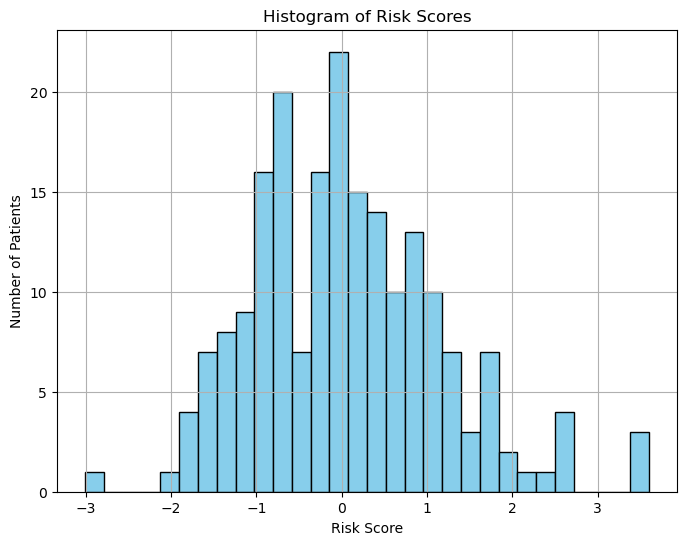

In [96]:

################################################################################
# 3. Stratify into high/low risk using median
################################################################################

log("Plotting Histogram of Risk Scores!")

# Basic matplotlib histogram
plt.figure(figsize=(8, 6))
plt.hist(risk_scores, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()
#plt.savefig(os.path.join(output_dir, "Hist_riskscores.png"), dpi=300)  
#plt.close()


In [103]:

################################################################################
# 4. Kaplan-Meier Plot
################################################################################

log("Plotting Kaplan-Meier curves for high/low risk groups defined by median and predictiveness cutoffs!")

for cutoff in [median_cutoff, predictiveness_cutoff]:

    print(f"\nCutoff = {cutoff:.4f}\n",flush=True)

    # Use the median cutoff from training to assign risk groups in test set
    clin_test["risk_group"] = pd.Series(["high" if x > cutoff else "low" for x in risk_scores], index=risk_scores.index)

    summary = clin_test.groupby("risk_group")["RFi_event"].value_counts().unstack()
    print(summary)

    # Initialize KM fitters
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    # Masks
    mask_low = clin_test["risk_group"] == "low"
    mask_high = clin_test["risk_group"] == "high"

    # Fit
    kmf_low.fit(clin_test.loc[mask_low, "RFi_years"], clin_test.loc[mask_low, "RFi_event"], label="Low risk")
    kmf_high.fit(clin_test.loc[mask_high, "RFi_years"], clin_test.loc[mask_high, "RFi_event"], label="High risk")

    # plot
    # Allocate space for KM plot + risk table
    fig, ax = plt.subplots(figsize=(8, 6))

    kmf_low.plot(ax=ax, ci_show=True)
    kmf_high.plot(ax=ax, ci_show=True)

    # Add risk table
    add_at_risk_counts(kmf_low, kmf_high, ax=ax,rows_to_show= ["At risk"])
    ax.set_xlabel("Time (years)")
    ax.set_ylabel("Recurrence Probability")

    results = logrank_test(
        clin_test.loc[mask_low, "RFi_years"],
        clin_test.loc[mask_high, "RFi_years"],
        event_observed_A=clin_test.loc[mask_low, "RFi_event"],
        event_observed_B=clin_test.loc[mask_high, "RFi_event"]
    )

    p_value = results.p_value

    plt.title(f"Kaplan-Meier: High vs. Low Risk Groups\nLog-rank p-value = {p_value:.4f}; RS cuttoff = {cutoff:.4f}")
    #plt.xlabel("Time (years)")
    plt.ylabel("Recurrence Probability")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"KM_risk_groups_{cutoff:.4f}.png"), dpi=300) 
    plt.close()



=== Plotting Kaplan-Meier curves for high/low risk groups defined by median and predictiveness cutoffs! ===


Cutoff = -0.1941

RFi_event    0   1
risk_group        
high        97  15
low         88   1

Cutoff = 0.0850

RFi_event     0   1
risk_group         
high         75  15
low         110   1


In [ ]:

################################################################################
# 5. Univariate Cox regression with risk score
################################################################################

log("Calculating univariate Cox regression and plotting hazard ratio for risk score!")

# Prepare dataframe for lifelines
df_lifelines = clin_test[["RFi_event", "RFi_years", "risk_score"]].copy()
df_lifelines.columns = ["event", "time", "risk_score"]  # lifelines naming

# Fit univariate Cox model
cph = CoxPHFitter()
cph.fit(df_lifelines, duration_col="time", event_col="event")

# Print summary
print("\nUnivariate Cox regression (risk score):")
cph.print_summary()

# Optional: check event distribution
print("\nEvent value counts:")
print(clin_test["RFi_event"].value_counts())

# Generate the forest plot
ax = cph.plot(hazard_ratios=True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "cox_forest_plot.png"), dpi=300, bbox_inches="tight")  
plt.close()